<a href="https://colab.research.google.com/github/zia207/High_Performance_Computing_Python/blob/main/Notebook/04_01_02_hpc_data_wrangling_datatable_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

#  Data Wrangling with **datatable**

The `datatable` package is a high-performance Python library designed for efficient data manipulation and analysis, particularly for large datasets. It provides a Frame object, similar to a pandas DataFrame, but is optimized for speed and memory efficiency, leveraging multi-threaded operations and a columnar data structure. Built on top of C++ for performance, `datatable` excels in tasks like reading/writing large CSV files, filtering, grouping, and joining data, making it a powerful alternative to pandas for big data workflows.

## Why `datatable` in Python?

The **`datatable`** package in Python is a fast, memory-efficient library for working with tabular data—especially large datasets (millions to billions of rows). It’s designed to be intuitive, concise, and blazingly fast, drawing heavy inspiration from R’s `data.table`.

Key advantages:
- **Speed**: Often 5–100x faster than pandas for large data.
- **Memory efficiency**: Uses lazy evaluation and columnar storage.
- **Concise syntax**: Less code for common operations like filtering, grouping, and joins.
- **Seamless interoperability**: Easily convert to/from pandas, NumPy, or Arrow.

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Check and Install Required Python Packages

In [2]:
import pkg_resources
import subprocess
import sys

# List of required packages
packages = [
    'pandas',
    'pyarrow',
    'fastparquet',
    'datatable',
    'pandas',
    'matplotlib',
    'seaborn'

]

# Check for missing packages and install them
for package in packages:
    try:
        pkg_resources.get_distribution(package)
    except pkg_resources.DistributionNotFound:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Verify installed packages
for package in packages:
    try:
        pkg_resources.get_distribution(package)
        print(f"{package} is installed.")
    except pkg_resources.DistributionNotFound:
        print(f"{package} failed to install.")

/tmp/ipython-input-1572386532.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Installing fastparquet...
Installing datatable...
pandas is installed.
pyarrow is installed.
fastparquet is installed.
datatable is installed.
pandas is installed.
matplotlib is installed.
seaborn is installed.


In [4]:
# Load Required Libraries
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datatable import dt, fread, f, by, join, update, ifelse

## Data

The dataset is in Parquet format, which DuckDB can query directly without loading into memory. For reproducibility:

- Download the January 2023 data from:
[https://d37ci07v2hxiua.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet](https://d37ci07v2hxiua.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet) (about 47 MB, ~3 million rows).

- We saved  it to a local folder, e.g., `/home/zia207/Dropbox/WebSites/R_Website/Quarto_Projects/R_Beginner/Data/yellow_tripdata_2023-01.parquet`.

- We'll also use the Taxi Zone Lookup CSV for joins: Download from [https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv](https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv).

The dataset includes columns like `VendorID`, `tpep_pickup_datetime`, `tpep_dropoff_datetime`, `passenger_count`, `trip_distance`, `PULocationID`, `DOLocationID`, `fare_amount`, `total_amount`, etc.

All data set use in this exercise can be downloaded from my [Dropbox](https://www.dropbox.com/scl/fi/ws1ol2kks3ms7rguoh310/yellow_tripdata_2023.parquet?rlkey=3tvgguudixfcizoet9vrxzwvl&dl=0) accounts.

### Load Data

In [5]:
# Define data folder (adjust path as needed)
data_folder = "/content/drive/MyDrive/Data/CSV_files/"

# Main trip data (CSV)
file_path = f"{data_folder}yellow_trip_data_2023_01_pandas.csv"
df = fread(file_path)

# Zone lookup data
zone_path = f"{data_folder}taxi_zone_lookup.csv"
zones = fread(zone_path)

print("Trip data shape:", df.shape)
print("Zones data shape:", zones.shape)

Trip data shape: (3066766, 19)
Zones data shape: (265, 4)


### Converting Between `datatable` and `pandas`

In [6]:
# datatable → pandas
df_pandas = df.to_pandas()

# pandas → datatable
df_dt = dt.Frame(df_pandas)

### Creating New Columns (Feature Engineering)

In [24]:
# --- Trip Duration (in minutes) ---
# Use pandas for datetime arithmetic (datatable doesn't support subtraction)
df_pd = df[:, ["tpep_pickup_datetime", "tpep_dropoff_datetime"]].to_pandas()
df_pd['tpep_pickup_datetime'] = pd.to_datetime(df_pd['tpep_pickup_datetime'])
df_pd['tpep_dropoff_datetime'] = pd.to_datetime(df_pd['tpep_dropoff_datetime'])
df_pd['trip_duration'] = (df_pd['tpep_dropoff_datetime'] - df_pd['tpep_pickup_datetime']).dt.total_seconds() / 60
df[:, "trip_duration"] = df_pd['trip_duration'].values

# --- Fare per mile (avoid division by zero) ---
df[f.trip_distance > 0, "fare_per_mile"] = f.fare_amount / f.trip_distance

# --- Extract hour ---
df[:, "pickup_hour"] = dt.time.hour(f.tpep_pickup_datetime)

# --- Time of day ---
df[:, "time_of_day"] = ifelse(
    (f.pickup_hour >= 6) & (f.pickup_hour < 12), "Morning",
    ifelse(
        (f.pickup_hour >= 12) & (f.pickup_hour < 18), "Afternoon",
        ifelse(
            (f.pickup_hour >= 18) & (f.pickup_hour < 22), "Evening", "Night"
        )
    )
)

# --- Is weekend? (Saturday=5, Sunday=6) ---
df[:, "is_weekend"] = (dt.time.day_of_week(f.tpep_pickup_datetime) == 5) | \
                      (dt.time.day_of_week(f.tpep_pickup_datetime) == 6)

df.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,…,trip_duration,fare_per_mile,pickup_hour,time_of_day,is_weekend
,▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪,▪▪▪▪,▪
0,2,2023-01-01T00:32:10,2023-01-01T00:40:36,1,0.97,1,N,161,141,2,…,8.43333,9.58763,0,Night,0
1,2,2023-01-01T00:55:08,2023-01-01T01:01:27,1,1.1,1,N,43,237,1,…,6.31667,7.18182,0,Night,0
2,2,2023-01-01T00:25:04,2023-01-01T00:37:49,1,2.51,1,N,48,238,1,…,12.75,5.93625,0,Night,0


### Selecting Columns

In [25]:
selected = df[:, ["tpep_pickup_datetime", "passenger_count", "trip_distance", "fare_amount", "PULocationID"]]
selected.head(3)

,tpep_pickup_datetime,passenger_count,trip_distance,fare_amount,PULocationID
,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪
0,2023-01-01T00:32:10,1,0.97,9.3,161
1,2023-01-01T00:55:08,1,1.1,7.9,43
2,2023-01-01T00:25:04,1,2.51,14.9,48


### Joining with Zone Lookup Data

Python datatable does not support `table joins` natively. You must use pandas.`merge()` as a workaround

In [31]:
# Convert to pandas
df_pd = df.to_pandas()
zones_pd = zones.to_pandas()

# Perform left join
joined_pd = pd.merge(
    df_pd,
    zones_pd,
    left_on="PULocationID",
    right_on="LocationID",
    how="left"
)

# Convert back to datatable (optional)
joined = dt.Frame(joined_pd)

###  Filtering Rows

In [32]:
# Filter: passenger_count > 2 AND trip_distance > 5
filtered = df[(f.passenger_count > 2) & (f.trip_distance > 5), :]
print("Filtered rows:", filtered.nrows)

# Manhattan trips with fare > $20
manhattan = joined[
    (f.Borough == "Manhattan") & (f.fare_amount > 20),
    ["tpep_pickup_datetime", "trip_distance", "fare_amount", "Borough"]
]
manhattan.head(5)

Filtered rows: 40222


,tpep_pickup_datetime,trip_distance,fare_amount,Borough
,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪
0,2023-01-01T00:27:12,11.7,45.7,Manhattan
1,2023-01-01T00:43:37,7.3,33.8,Manhattan
2,2023-01-01T00:34:44,3.23,26.1,Manhattan
3,2023-01-01T00:04:33,4.5,20.5,Manhattan
4,2023-01-01T00:19:12,5.7,26.8,Manhattan


### Aggregation & Grouping

In [34]:
# Convert to pandas for aggregation
joined_pd = joined.to_pandas()

# Long trips (>10 miles) by Borough using pandas
long_trips_pd = joined_pd[
    joined_pd['trip_distance'] > 10
].groupby('Borough').agg(
    avg_fare=('fare_amount', 'mean'),
    trip_count=('fare_amount', 'count')
).reset_index()
print(long_trips_pd)

# Total trips and avg distance by Borough using pandas
borough_summary_pd = joined_pd.groupby('Borough').agg(
    total_trips=('trip_distance', 'count'),
    avg_distance=('trip_distance', 'mean')
).reset_index()
print(borough_summary_pd)

         Borough   avg_fare  trip_count
0          Bronx  50.649144         818
1       Brooklyn  53.814229        2173
2            EWR  81.625806          31
3      Manhattan  61.911018       65249
4         Queens  64.634267      167777
5  Staten Island  62.364162         185
6        Unknown  59.351723        8058
         Borough  total_trips  avg_distance
0          Bronx         4162      5.296593
1       Brooklyn        18076      5.677405
2            EWR          410      1.594780
3      Manhattan      2715369      2.883807
4         Queens       286645     12.320490
5  Staten Island          341     11.356774
6        Unknown        41763      7.362869


### Summary Statistics

In [35]:
# Multiple stats
summary = df[:, {
    "mean_fare": dt.mean(f.fare_amount),
    "median_fare": dt.median(f.fare_amount),
    "mean_distance": dt.mean(f.trip_distance),
    "mean_passengers": dt.mean(f.passenger_count)
}]
print(summary)

   | mean_fare  median_fare  mean_distance  mean_passengers
   |   float64      float64        float64          float64
-- + ---------  -----------  -------------  ---------------
 0 |   18.3671         12.8        3.84734          1.36253
[1 row x 4 columns]



### Column Reordering & Renaming

In [36]:
# Add year
joined[:, "pickup_year"] = dt.time.year(f.tpep_pickup_datetime)

# Reorder
new_order = ["PULocationID", "Borough", "DOLocationID", "Zone", "pickup_year", "fare_amount"]
joined = joined[:, new_order]

# Rename
joined.names = {"PULocationID": "PICKUP_ZONE_ID"}

joined.head(3)

,PICKUP_ZONE_ID,Borough,DOLocationID,Zone,pickup_year,fare_amount
,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪▪▪▪▪
0,161,Manhattan,141,Midtown Center,2023,9.3
1,43,Manhattan,237,Central Park,2023,7.9
2,48,Manhattan,238,Clinton East,2023,14.9


### Reshaping Data

In [41]:
# Convert to pandas for pivoting
pivot_data_pd = joined[:, ["pickup_year", "Borough", "fare_amount"]].to_pandas()

# Pivot wider using pandas
wide_pd = pivot_data_pd.pivot_table(
    index="pickup_year",
    columns="Borough",
    values="fare_amount",
    aggfunc='mean'
).reset_index()
print(wide_pd.head())

# Melt back to long using pandas
long_pd = wide_pd.melt(
    id_vars=["pickup_year"],
    var_name="Borough",
    value_name="fare_amount"
)
print(long_pd.head())

Borough  pickup_year      Bronx   Brooklyn         EWR  Manhattan     Queens  \
0               2008        NaN        NaN         NaN        NaN  35.000000   
1               2022        NaN  45.000000  117.500000  18.025000  39.585714   
2               2023  30.242775  26.808403   87.842304  14.775313  49.983325   

Borough  Staten Island   Unknown  
0                  NaN       NaN  
1                  NaN  42.50000  
2             48.74305  29.12696  
   pickup_year   Borough  fare_amount
0         2008     Bronx          NaN
1         2022     Bronx          NaN
2         2023     Bronx    30.242775
3         2008  Brooklyn          NaN
4         2022  Brooklyn    45.000000


### Visualization

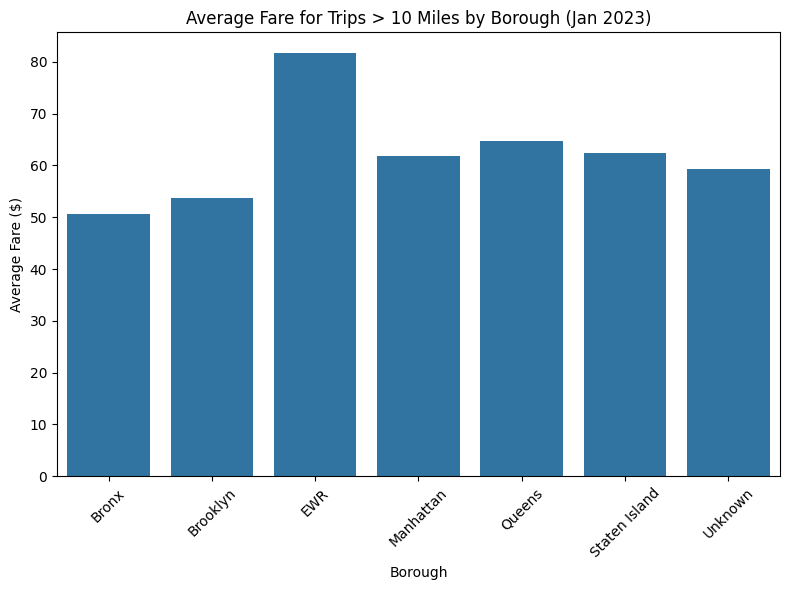

In [44]:
# Convert to pandas for plotting
lt_pd = long_trips_pd

plt.figure(figsize=(8, 6))
sns.barplot(data=lt_pd, x="Borough", y="avg_fare")
plt.title("Average Fare for Trips > 10 Miles by Borough (Jan 2023)")
plt.ylabel("Average Fare ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Summary and Conclusions

This notebook demonstrates data wrangling using `datatable` for efficient handling of large datasets, including loading, basic feature engineering, selection, and filtering. For more complex operations like joining, advanced aggregations, reshaping, and visualization, it transitions to using pandas and seaborn due to current limitations or implementation details in `datatable`.


## Resources

## Resources

*   **datatable Documentation:** The official documentation for the `datatable` Python library provides detailed information on its features and usage: [https://datatable.readthedocs.io/en/latest/](https://datatable.readthedocs.io/en/latest/)
*   **pandas Documentation:** The comprehensive documentation for the `pandas` library is an essential resource for data manipulation and analysis in Python: [https://pandas.pydata.org/docs/](https://pandas.pydata.org/docs/)
*   **Seaborn Documentation:** The official documentation for `seaborn` provides examples and guides for creating statistical visualizations: [https://seaborn.pydata.org/](https://seaborn.pydata.org/)
*   **NYC Taxi & Limousine Commission (TLC) Data:** The source of the trip data and zone lookup file used in this notebook: [https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)
*   **Dropbox Data Link:** The specific Dropbox link provided in the notebook for downloading the dataset: [https://www.dropbox.com/scl/fi/ws1ol2kks3ms7rguoh310/yellow_tripdata_2023.parquet?rlkey=3tvgguudixfcizoet9vrxzwvl&dl=0](https://www.dropbox.com/scl/fi/ws1ol2kks3ms7rguoh310/yellow_tripdata_2023.parquet?rlkey=3tvgguudixfcizoet9vrxzwvl&dl=0)
*   **PyArrow:** A library for working with Apache Arrow, often used for efficient data interchange: [https://arrow.apache.org/docs/python/](https://arrow.apache.org/docs/python/)
*   **Fastparquet:** A Python library for reading and writing Parquet files: [https://github.com/dask/fastparquet](https://github.com/dask/fastparquet)